In [1]:
from pathlib import Path
import pandas as pd
pd.set_option('max_rows', 1024)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style(style="white")
sns.set_context("talk")
sns.set_palette("deep")

In [2]:
IDNET_PATH = Path(r"C:\Users\Fred\Documents\Insight\Gait Datasets\IDNet Database\IDNet_dataset")

In [123]:
def get_walk_data(user_id, walk_num, hz=60):
    """Return DataFrame of walk sensor data from IDNet individual/walk at 10ms intervals (resampled).
    Note the data may include NaN values since sensors are sampled at different frequencies or may skip measurements."""
    # Retrieve folder
    walkid = f"u{str(user_id).zfill(3)}_w{str(walk_num).zfill(3)}"
    folder = IDNET_PATH / walkid
    # For each sensor log, construct df from file
    dfs = []
    for log in folder.glob("*.log"):
        logtype = log.stem.split("_")[-1]  # accelerometer, gyroscope, etc.
        if logtype == "magnetometer":
            continue  # Skip magnetometer since not probably not useful
        df = pd.read_csv(log, sep="\t")
        # Read timestamp column as pandas Timedelta, starting from 0 ns
        df[f"{logtype}_timestamp"] = pd.to_timedelta(df[f"{logtype}_timestamp"], unit="ns")
        df = df.rename(columns={f"{logtype}_timestamp": "timestamp"})
        df = df.set_index("timestamp")
        dfs.append(df)
    merged_df = pd.concat(dfs, axis="columns")
    # Truncate each dataframe based on latest start / earliest end
    # Alternatively, truncate up to 10s from beginning and end to exclude for start/stop motions
    latest_start_time = max(merged_df.notna().idxmax().max(), merged_df.index[0] + pd.Timedelta("10s"))
    earliest_end_time = min(merged_df.notna()[::-1].idxmax().min(), merged_df.index[-1] - pd.Timedelta("10s"))
    # Sensors have different sampling freqs so resample
    merged_df = merged_df.resample(f"{round(1/hz * 1e9)}N").mean()
    merged_df = merged_df.loc[latest_start_time: earliest_end_time].copy()
    # Impute NaN values which are just resulting from a single skip
    merged_df = merged_df.fillna(method='pad', limit=1, axis=1)
    # Convert timestamp to relative times
    merged_df = merged_df.set_index(merged_df.index - merged_df.index[0])
    return merged_df

In [124]:
df = get_walk_data(1, 1)
df

,accelerometer_x_data,accelerometer_y_data,accelerometer_z_data,gravity_x_data,gravity_y_data,gravity_z_data,gyroscope_x_data,gyroscope_y_data,gyroscope_z_data,linearaccelerometer_x_data,linearaccelerometer_y_data,linearaccelerometer_z_data,rotvec_x_data,rotvec_y_data,rotvec_z_data
timestamp,,,,,,,,,,,,,,,
00:00:00,11.429413,13.207573,-2.905304,8.103873,3.159037,4.529665,0.531718,0.702713,0.356461,2.469551,8.889169,-6.133750,0.125135,-0.503378,-0.109172
00:00:00.016666,13.979088,14.226555,-5.206337,8.087636,3.173830,4.548332,0.424908,0.455414,0.650692,4.960106,10.732573,-8.508876,0.129443,-0.501342,-0.103510
00:00:00.033333,15.421730,11.941033,-7.016540,8.119404,3.151971,4.506664,0.228317,-0.400080,0.509181,7.306059,10.184879,-11.400933,0.132520,-0.502654,-0.095923
00:00:00.050000,15.555001,7.550972,-5.172806,8.220102,3.163183,4.311232,0.279221,-2.062047,-0.312215,7.476119,6.331973,-10.775755,0.134433,-0.511958,-0.093603
00:00:00.066666,16.564789,5.897476,-0.312332,8.383242,3.289951,3.878669,0.767918,-3.855125,-1.246628,7.928491,3.172018,-6.888044,0.138575,-0.531976,-0.099265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:04:08.283338,2.613121,-1.830757,3.908226,9.641288,1.424021,1.089578,-0.401260,0.257202,0.114146,-9.200296,-2.816104,2.942783,0.339725,-0.573613,0.282038
00:04:08.300004,10.592896,-2.912445,4.788910,9.652172,1.372873,1.058064,-0.167908,-1.046778,0.402069,-4.107130,-3.700288,3.017058,0.336866,-0.576690,0.281167
00:04:08.316671,23.216965,-4.092888,6.345108,9.690366,1.251684,0.832537,-0.303520,-2.045136,0.910000,7.441155,-4.945405,4.926676,0.334870,-0.587709,0.279641


In [125]:
# Sample sequences from walk
def generate_walk_chunks(df, chunksize=512, is_valid=True):
    """Split df into multiple chunks of data. If is_valid is True, only yields non-NAN data (e.g. ignores sensor skips).
    Chunk size recommended to be power-of-2 for downstream FFT: https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
    """
    count = 0
    while count < (len(df) - chunksize):
        subdf = df.iloc[count:count + chunksize, :]
        if not subdf.isna().any(axis=None):  # Return only non-NA
            yield subdf
        count += chunksize

In [126]:
chunk_generator = generate_walk_chunks(df)

In [127]:
chunk = next(chunk_generator)

In [128]:
def plot_log(df, logtype):
    f, ax = plt.subplots(figsize=(15, 5))
    df = df[[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data"]].copy()
    df["mag"] = np.linalg.norm(df.values, axis=1)
    df.plot.line(y=[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data", "mag"], ax=ax)
    ax.set_ylabel(f"{logtype}")
    ax.set_xlabel("Time")
    ax.legend(["x", "y", "z", "mag"], loc="best")
    sns.despine()

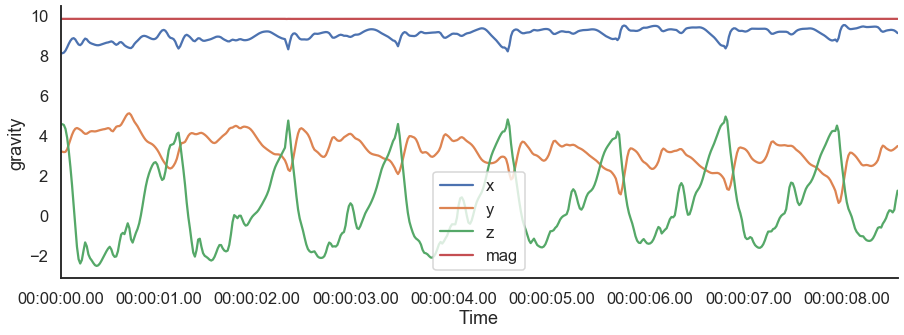

In [129]:
plot_log(chunk, "gravity")

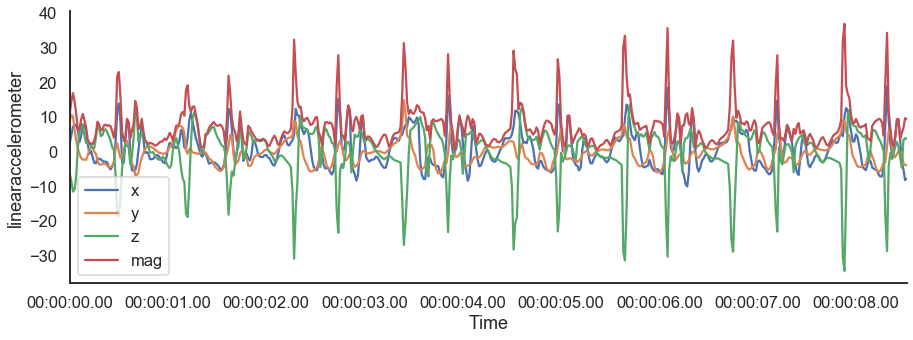

In [130]:
plot_log(chunk, "linearaccelerometer")

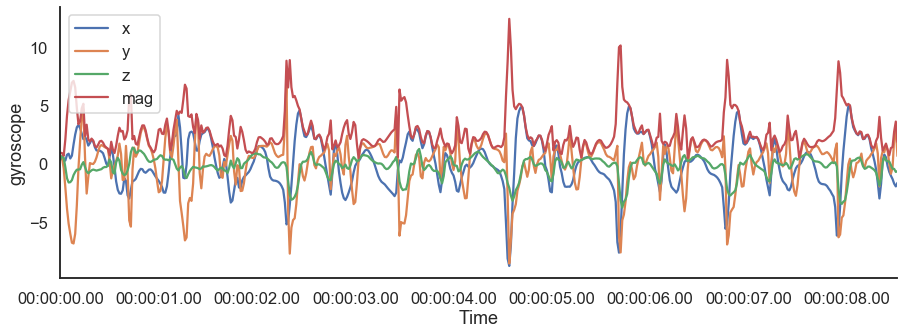

In [131]:
plot_log(chunk, "gyroscope")

## Fourier analysis

In [132]:
def get_normalized_sensor_data(df, logtype):
    norm_acc = np.linalg.norm(df[[f"{logtype}_x_data", f"{logtype}_y_data", f"{logtype}_z_data"]].values, axis=1)
    norm_acc = (norm_acc - norm_acc.mean()) / (np.percentile(norm_acc, 99) - np.percentile(norm_acc, 1))
    return norm_acc

In [133]:
from scipy.fft import fft, ifft
from scipy.signal import correlate, find_peaks, spectrogram

In [134]:
f_s = 60  # Sampling rate of 60 Hz
f_s

60

In [135]:
def get_fft(signal, f_s):
    """f_s = sampling rate (measurements/second)"""
    T = 1/f_s
    N = len(signal)
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])  # take abs (remove phase component)
    return f_values, fft_values

In [136]:
def get_top_signal_peaks(x, y, n):
    peak_idx, peak_props = find_peaks(y, height=0)  # Specify height to force peak height computation
    peak_heights, peak_idx = zip(*sorted(zip(peak_props["peak_heights"], peak_idx), reverse=True)[:n])
    return f_val[list(peak_idx)], np.array(peak_heights)

In [137]:
def plot_fft(f_s, *signals):
    f, ax = plt.subplots(figsize=(15, 5))
    f_vals = []
    fft_vals = []
    for i, signal in enumerate(signals):
        f_val, fft_val = get_fft(signal, f_s)
        f_vals.append(f_val)
        fft_vals.append(fft_val)
        ax.plot(f_val, fft_val, "--" if i%2==1 else "-", label=i)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    sns.despine()
    return list(zip(f_vals, fft_vals))

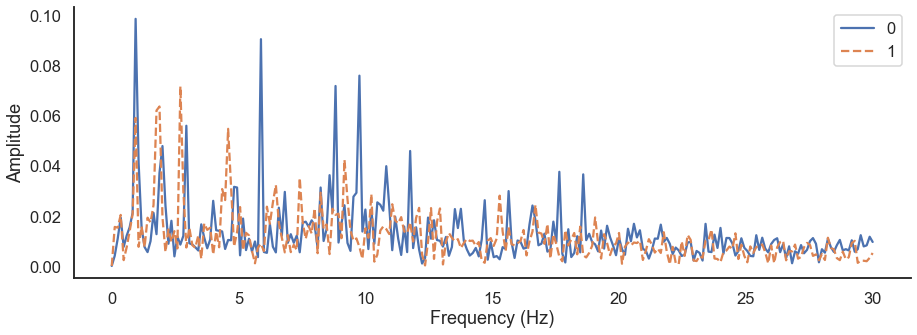

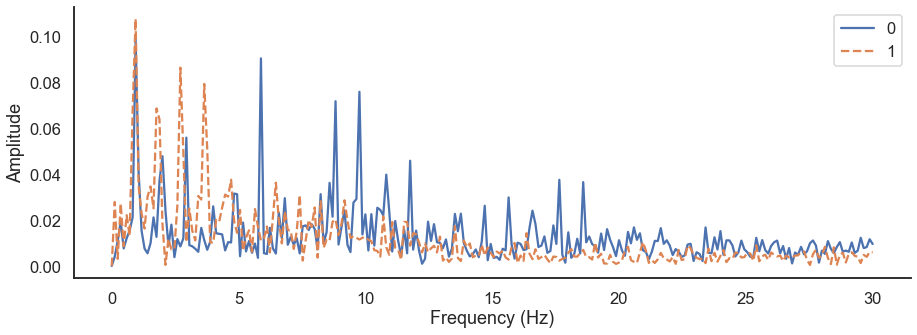

In [176]:
# plot subsequences within the same walk
norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
next_chunk = next(chunk_generator)
(f1, fft1), (f2, fft2) = plot_fft(f_s, norm_acc, get_normalized_sensor_data(next_chunk, "linearaccelerometer"))
(f1, fft1), (f2, fft2) = plot_fft(f_s, norm_acc, get_normalized_sensor_data(next_chunk, "gyroscope"))

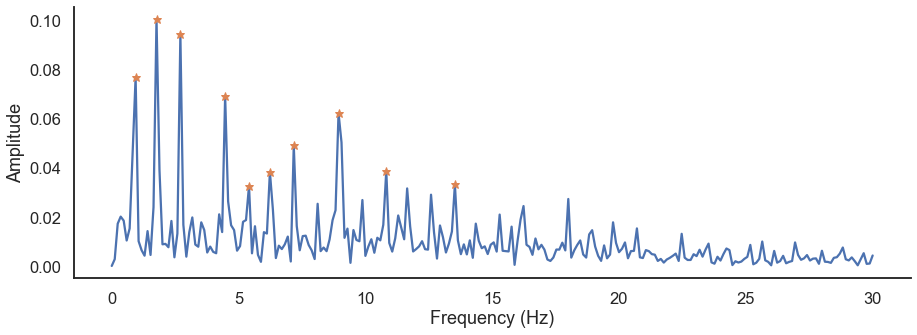

In [139]:
f, ax = plt.subplots(figsize=(15, 5))
f_val, fft_val = get_fft(norm_acc, f_s)
ax.plot(f_val, fft_val)
ax.plot(*get_top_signal_peaks(f1, fft1, 10), "*")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
sns.despine()

Text(0.5, 0, 'Time (sec)')

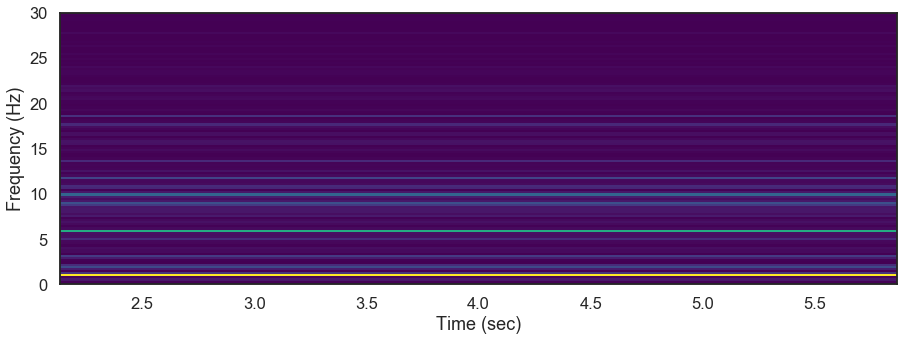

In [183]:
# checking that frequencies are unchanging across the entire walk recording
freq, time, Sxx = spectrogram(norm_acc, f_s)
f, ax = plt.subplots(figsize=(15, 5))
ax.pcolormesh(time, freq, Sxx, cmap="viridis")
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (sec)")

## Convert data to feature vectors

- Iterate over users
- Chunk recording information and convert to feature (linearaccelerometer + gyroscope data)
- Label feature with user and walk number

In [141]:
# Get number of walks per user
counts = {}
for folder in IDNET_PATH.glob("*"):
    user_id = int(folder.stem[1:4])
    if user_id not in counts:
        counts[user_id] = 1
    else:
        counts[user_id] += 1

In [142]:
users_with_multiple_walks = [user for user, count in counts.items() if count > 1]
len(users_with_multiple_walks)

31

In [143]:
features = []
for user in tqdm(users_with_multiple_walks, desc="User"):
    for walk in range(1, counts[user]+1):
        df = get_walk_data(user, walk)
        for chunk in generate_walk_chunks(df):
            norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
            norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
            f_acc, fft_acc = get_fft(norm_acc, f_s)
            peak_f_acc, peak_fft_acc = get_top_signal_peaks(f_acc, fft_acc, 10)
            f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
            peak_f_gyro, peak_fft_gyro = get_top_signal_peaks(f_gyro, fft_gyro, 10)
            # concatenate the features
            feature_vector = np.concatenate([[user, walk], peak_f_acc, peak_fft_acc, peak_f_gyro, peak_fft_gyro])
            features.append(feature_vector)

In [144]:
df_features = pd.DataFrame(features, 
    columns=["user_id", "walk_id", 
           *[f"acc_f{i}" for i in range(10)], *[f"acc_fft{i}" for i in range(10)],
           *[f"gyro_f{i}" for i in range(10)], *[f"gyro_fft{i}" for i in range(10)]
])
df_features["user_id"] = df_features["user_id"].astype(int)
df_features["walk_id"] = df_features["walk_id"].astype(int)

In [145]:
df_features

,user_id,walk_id,acc_f0,acc_f1,acc_f2,acc_f3,acc_f4,acc_f5,acc_f6,acc_f7,...,gyro_fft0,gyro_fft1,gyro_fft2,gyro_fft3,gyro_fft4,gyro_fft5,gyro_fft6,gyro_fft7,gyro_fft8,gyro_fft9
0,1,1,1.764706,2.705882,0.941176,4.470588,8.941176,7.176471,10.823529,6.235294,...,0.120997,0.114568,0.070393,0.054650,0.042814,0.037852,0.036600,0.032279,0.032166,0.030448
1,1,1,1.764706,2.705882,4.470588,0.941176,6.941176,6.117647,8.823529,9.058824,...,0.140728,0.112847,0.078510,0.044486,0.043454,0.035834,0.033585,0.032406,0.029489,0.026667
2,1,1,1.882353,0.941176,2.823529,4.588235,2.588235,9.058824,11.176471,9.294118,...,0.128348,0.094436,0.059027,0.042902,0.042354,0.040536,0.038504,0.036305,0.032103,0.031322
3,1,1,1.882353,4.588235,2.823529,0.941176,9.176471,6.470588,11.058824,10.117647,...,0.160637,0.106089,0.067237,0.067148,0.062007,0.040268,0.037267,0.035514,0.026900,0.025633
4,1,1,1.882353,2.705882,0.941176,4.588235,9.176471,7.294118,6.352941,11.058824,...,0.141861,0.109169,0.100240,0.081770,0.046791,0.041726,0.039080,0.037452,0.031623,0.028524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577,46,2,0.941176,2.941176,8.823529,9.764706,5.882353,2.000000,10.000000,7.882353,...,0.158543,0.060199,0.057142,0.052602,0.047011,0.046464,0.046113,0.042558,0.040621,0.040463
4578,46,2,0.941176,9.764706,4.941176,2.000000,8.823529,10.705882,5.882353,3.882353,...,0.222493,0.074743,0.067043,0.058842,0.049832,0.041367,0.038464,0.037931,0.036184,0.033354
4579,46,2,0.941176,9.764706,10.705882,2.000000,5.882353,8.823529,2.941176,4.941176,...,0.166771,0.084528,0.079186,0.066046,0.058000,0.056789,0.054959,0.051471,0.045372,0.037025
4580,46,2,0.941176,2.941176,5.764706,2.000000,1.764706,9.764706,9.529412,8.588235,...,0.148051,0.073614,0.068716,0.058846,0.038766,0.037630,0.034491,0.034253,0.032951,0.032863


## Fit data to initial model

- Make sure when splitting into training/test data that we don't mix walks in either set (leakage)

In [146]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

In [147]:
train = df_features[df_features["walk_id"] == 1].copy()
y_train, X_train = train.iloc[:, 0], train.iloc[:, 2:]
test = df_features[df_features["walk_id"] != 1].copy()
y_test, X_test = test.iloc[:, 0], test.iloc[:, 2:]

#### random forest

In [148]:
trees = RandomForestClassifier(class_weight="balanced")

In [149]:
trees.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [150]:
train["predicted_user"] = trees.predict(X_train)
test["predicted_user"] = trees.predict(X_test)

Text(0.5, 1.0, 'Training set confusion matrix')

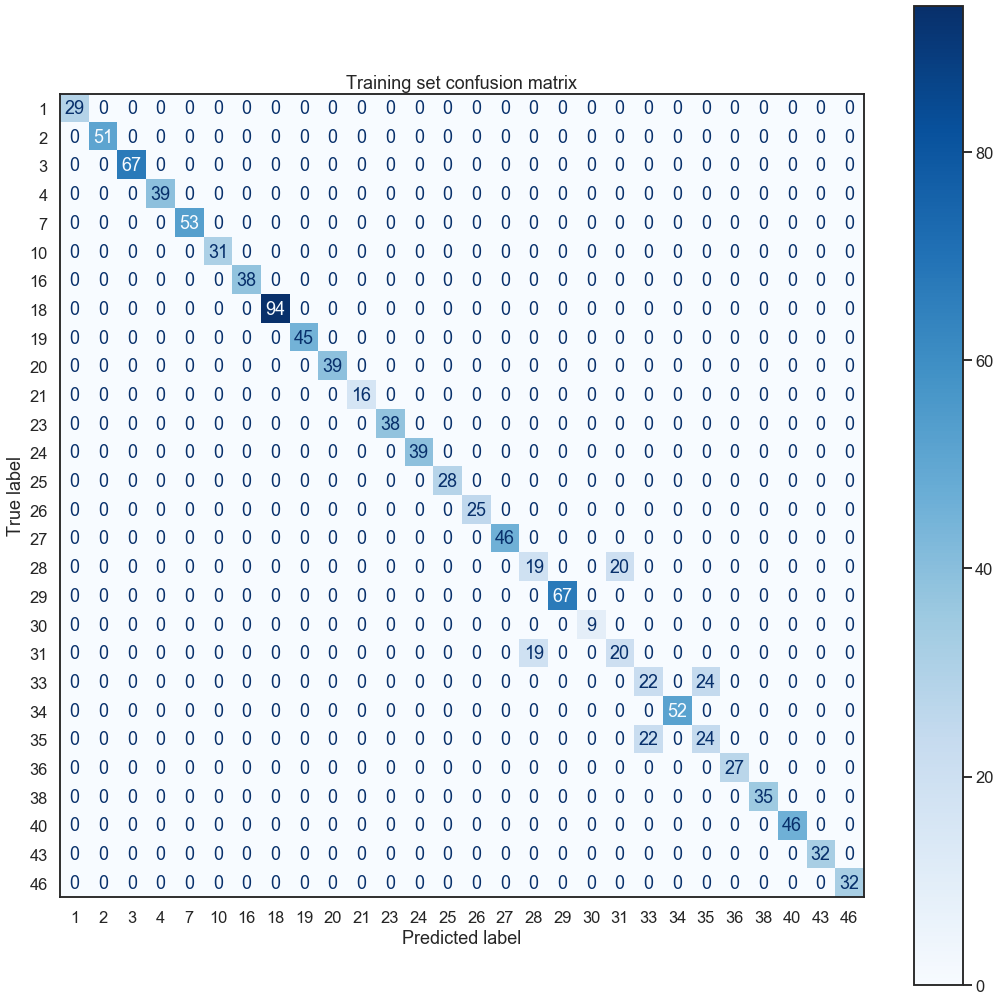

In [172]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_train, y_train, ax=ax, cmap="Blues")
ax.set_title("Training set confusion matrix")
# ax.images[-1].colorbar.remove()

Text(0.5, 1.0, 'Test set confusion matrix')

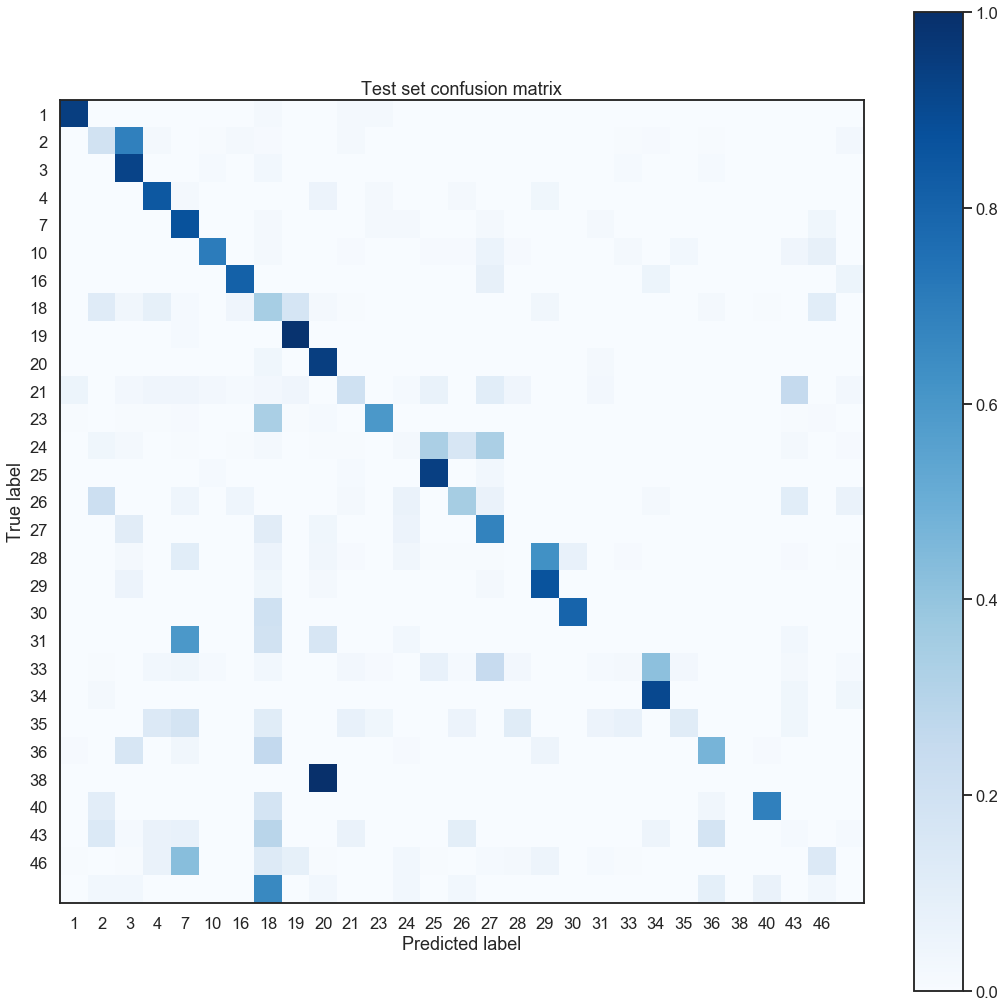

In [171]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_test, y_test, ax=ax, cmap="Blues", normalize="true", include_values=False)
ax.set_title("Test set confusion matrix")